In [1]:
# General Imports
import os, sys
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, random_split, Dataset
sys.path.insert(0, '../')
from utils.fixes import global_seed

global_seed(42)
%matplotlib inline

Global seed set to 42


In [7]:
from gensim.models import word2vec
model = word2vec.Word2Vec.load("model_300dim.pkl")

In [8]:
from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec, sentences2vec
from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec, sentences2vec
from gensim.models import word2vec

In [10]:
def sentences2vec(sentences, model, unseen=None):
    """Generate vectors for each sentence (list) in a list of sentences. Vector is simply a
    sum of vectors for individual words.

    Parameters
    ----------
    sentences : list, array
        List with sentences
    model : word2vec.Word2Vec
        Gensim word2vec model
    unseen : None, str
        Keyword for unseen words. If None, those words are skipped.
        https://stats.stackexchange.com/questions/163005/how-to-set-the-dictionary-for-text-analysis-using-neural-networks/163032#163032

    Returns
    -------
    np.array
    """

    keys = set(model.wv.key_to_index)
    vec = []

    if unseen:
        unseen_vec = model.wv.get_vector(unseen)

    for sentence in sentences:
        if unseen:
            vec.append(sum([model.wv.get_vector(y) if y in set(sentence) & keys
                       else unseen_vec for y in sentence]))
        else:
            vec.append(sum([model.wv.get_vector(y) for y in sentence
                            if y in set(sentence) & keys]))
    return np.array(vec)

In [11]:
def generate_mol_vector(mol):
    mol_sentence = MolSentence(mol2alt_sentence(mol, 1))
    print(mol_sentence)
    mol2vec = DfVec(sentences2vec(mol_sentence, model, unseen='UNK'))
    return mol2vec.vec

In [12]:
import time
CALLS = []
merged = pd.read_csv('history.csv')
target = merged.score.values
def get_score(id):
    global CALLS
    CALLS.append(id)
    return target[id]

In [449]:
from sklearn.neighbors import NearestNeighbors
import torch
import warnings
from torch.nn import CosineSimilarity
import torch.nn.functional as F
class ChemicalSpace:
    def __init__(self, file):
        if file.split('.')[-1] == 'csv':

            compounds = pd.read_csv(file, nrows=1000)
        elif file.split('.')[-1] == 'smi':
            raise NotImplementedError
        else:
            raise NotImplementedError
        self.compounds = compounds
        self.compounds['mol'] = self.compounds['smiles'].apply(lambda x: Chem.MolFromSmiles(x))
        self.compounds['mol_sentence'] = self.compounds.apply(lambda x: MolSentence(mol2alt_sentence(x['mol'], 1)), axis=1)
        self.mol2vec = [DfVec(x) for x in sentences2vec(self.compounds['mol_sentence'], model, unseen='UNK')]
        self.mol2vec = np.array([x.vec for x in self.mol2vec])
        split = {f'vec_{i}': self.mol2vec[:, i] for i in range(self.mol2vec.shape[1])}
        self.vecs = pd.DataFrame(split)
        self.scores_cache = {}
        self.iter_neighbors = []
        self.cosine = CosineSimilarity(dim=1, eps=1e-6)
    def init_knn(self, n_neighbors=5):
        self.nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree').fit(self.mol2vec)
    def get_neighbors(self, vec, return_distance=False):
        if len(vec.shape) == 1:
            vec = vec.reshape(1, -1)
        return self.nbrs.kneighbors(vec, return_distance=return_distance)
    def set_objective(self, objective, **kwargs):
        # objective is a function that takes in an id and returns a score
        self.objective = objective
        self.objective_kwargs = kwargs
    def get_objective(self, id):
        if id not in self.scores_cache:
            self.scores_cache[id] = self.objective(id, **self.objective_kwargs)
        return self.scores_cache[id]
    def reset_neighbors(self):
        self.iter_neighbors = []
    def add_step_neighbors(self, neighbors):
        self.iter_neighbors.append(neighbors)
    def f(self, X):
        X_numpy = X.detach().numpy()
        print(f'X: {X_numpy}')
        # get neighbors
        neighbors = self.get_neighbors(X_numpy)[0]
        # add neighbors to list of neighbors
        self.add_step_neighbors(neighbors)
        # get scores of neighbors
        scores = torch.tensor([self.get_objective(i) for i in neighbors], dtype=torch.float64, requires_grad=True)
        # get coordinates of neighbors
        coords = torch.tensor([self.mol2vec[i] for i in neighbors], dtype=torch.float64, requires_grad=True)
        # f(x) = distance weighted average of neighbors
        # distance weighted average = sum of scores * (1 / distance)
        distance = torch.sqrt(torch.sum((coords - X)**2, dim=1))
        print(f'distance: {distance}')
        distance_weights = torch.exp(-distance) / torch.sum(torch.exp(-distance))
        print(f'distance weights: {distance_weights}')
        score = torch.sum(scores * distance_weights)
        print(f'scores: {score}')
        return score

In [450]:
# test 3d tensor
debug_X = torch.rand(1,3, requires_grad=True)
print(debug_X)
debug_neighbors = torch.rand(5,3, requires_grad=True)
debug_neighbors

tensor([[0.7634, 0.0582, 0.6685]], requires_grad=True)


tensor([[0.0164, 0.8107, 0.8304],
        [0.6901, 0.9564, 0.1327],
        [0.2738, 0.9480, 0.9091],
        [0.6191, 0.3599, 0.4604],
        [0.9305, 0.9305, 0.0070]], requires_grad=True)

In [451]:
# calculte distance
debug_distance = torch.sum((debug_neighbors - debug_X)**2, dim=1)
print(debug_distance)

tensor([1.1504, 1.0990, 1.0893, 0.1551, 1.2263], grad_fn=<SumBackward1>)


In [452]:
sample_scores = torch.tensor([-15.2, -11, -9, -10.2, -16], dtype=torch.float64, requires_grad=True)

In [453]:
# calculate distance weights
debug_distance_weights = torch.exp(-debug_distance) / torch.sum(torch.exp(-debug_distance))
print(debug_distance_weights)

tensor([0.1482, 0.1560, 0.1575, 0.4009, 0.1374], grad_fn=<DivBackward0>)


In [454]:
cos = CosineSimilarity(dim=1, eps=1e-6)
debug_cosine = cos(debug_neighbors, debug_X)
debug_cosine_weight = torch.exp(-debug_cosine) / torch.sum(torch.exp(-debug_cosine))
print(debug_cosine_weight)

tensor([0.2238, 0.2160, 0.1988, 0.1493, 0.2120], grad_fn=<DivBackward0>)


In [455]:
# calculate weighted average
debug_scores = sample_scores * debug_cosine_weight
print(debug_scores)

tensor([-3.4016, -2.3764, -1.7896, -1.5227, -3.3928], dtype=torch.float64,
       grad_fn=<MulBackward0>)


In [456]:
scores_sum = torch.sum(debug_scores)
print(scores_sum)

tensor(-12.4830, dtype=torch.float64, grad_fn=<SumBackward0>)


In [457]:
smi = 'history.csv'

In [458]:
space = ChemicalSpace(smi)

In [459]:
space.mol2vec[0]

array([ 8.74383450e+00, -1.16018171e+01, -1.64639606e+01,  2.49030704e+01,
       -4.36659193e+00, -2.88725400e+00, -3.82130928e+01, -9.44645226e-01,
        2.78874588e+01,  1.44985428e+01, -1.37672882e+01, -3.05505490e+00,
       -3.36061745e+01,  2.46499228e+00, -2.26407032e+01, -3.91858363e+00,
        1.39095078e+01, -1.38148193e+01, -1.34860544e+01,  2.49958038e+01,
        1.51091471e+01,  2.01385956e+01,  5.71145096e+01,  2.76117592e+01,
       -3.64472504e+01,  2.40855145e+00, -4.45863342e+00, -3.27441826e+01,
       -1.22627962e+00,  4.53340149e+00,  4.46113243e+01, -2.75367661e+01,
       -1.12057781e+01, -2.07878113e+01,  1.86894569e+01,  6.27529526e+00,
        6.13353109e+00, -4.18735266e+00,  3.14961910e+01,  6.25434399e+00,
       -9.40153694e+00, -2.65915489e+00, -1.38366556e+01,  1.26934290e+00,
       -4.35588570e+01,  1.95263195e+01, -6.62595928e-01,  3.02966557e+01,
       -2.12550201e+01,  1.83174229e+01,  1.97582321e+01, -2.16296597e+01,
       -9.72199821e+00, -

In [473]:
space.init_knn(n_neighbors=10)

In [474]:
space.get_neighbors(space.mol2vec[7])

array([[  7, 811,  76, 332, 211, 546, 309, 512, 542, 952]])

In [475]:
space.get_neighbors(space.mol2vec[844])

array([[844, 682, 617, 856, 106, 286, 768, 420, 333, 640]])

In [476]:
space.set_objective(get_score)

In [477]:
space.get_objective(84)

-10.766666666666666

In [478]:
debug_vector = torch.rand(300, requires_grad=True)

In [479]:
space.f(debug_vector)

X: [0.03470075 0.25365484 0.7400333  0.8144607  0.0717234  0.01600778
 0.14887923 0.86155325 0.35392433 0.2110039  0.63142055 0.729875
 0.18208545 0.6839389  0.71925616 0.7817689  0.6708361  0.71891224
 0.4646265  0.35715687 0.62500864 0.8837246  0.8935281  0.50666016
 0.6869309  0.25240391 0.37206239 0.90603495 0.5264355  0.5945254
 0.64140064 0.2261563  0.71485174 0.7154483  0.9220517  0.4425363
 0.7878508  0.61749536 0.28675437 0.3133337  0.42484075 0.26694977
 0.7348975  0.24219632 0.78385615 0.43757886 0.38053155 0.7914817
 0.02793717 0.44794178 0.04994172 0.94929075 0.4963584  0.43551838
 0.39897156 0.3123682  0.34368366 0.33832312 0.8839562  0.10662401
 0.58764267 0.18660718 0.04434258 0.8380186  0.67922884 0.04285097
 0.7046184  0.9765266  0.5697901  0.42099023 0.7305927  0.522799
 0.78667486 0.78466105 0.21511817 0.54648685 0.01041961 0.74638367
 0.36432153 0.17712992 0.31356502 0.08652329 0.555745   0.749493
 0.11516732 0.24613118 0.75293154 0.8027425  0.3898098  0.5156455
 0

tensor(-9.9955, dtype=torch.float64, grad_fn=<SumBackward0>)

In [480]:
from utils import *
global_seed(654)

Global seed set to 654


In [481]:
# optimize f(x)
X = torch.randn(300, requires_grad=True)

In [482]:
from torch.optim import Adam
optimizer = Adam([X], lr=10)

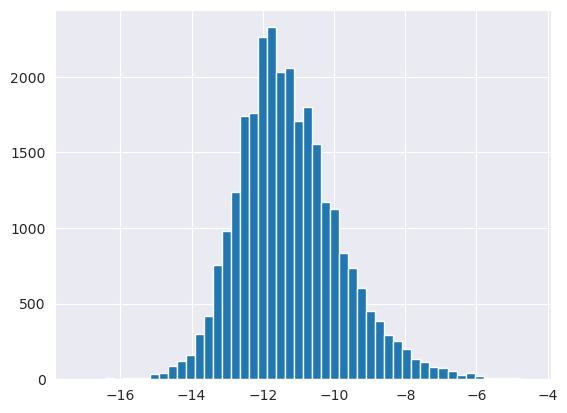

In [483]:
_ = plt.hist(target, bins=50)

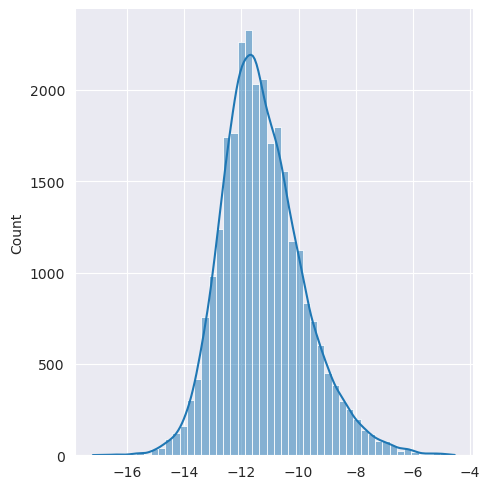

In [484]:
import seaborn as sns
_=sns.displot(target, bins=50, kde=True)

In [485]:
CALLS = []
best = 0
for i in range(10000):
    optimizer.zero_grad()
    loss = space.f(X)
    loss.backward()
    optimizer.step()
    if loss.item() < best:
        best = loss.item()
    if i % 500 == 0:
        print(f'Iteration: {i}', f'Loss: {loss.item()}')

X: [ 1.8102324e+00  1.0716679e+00  1.6925815e-02 -1.3976063e+00
 -9.3287617e-01  7.5174081e-01 -7.2389787e-01  2.8094202e-01
 -9.8214710e-01 -1.5351781e+00 -6.3785440e-01 -9.8285472e-01
  6.6317731e-01  1.7870525e+00  5.4952484e-01  2.0340319e-01
  2.9076493e-01  1.0618333e+00  2.3249211e-02  8.7478000e-01
 -1.8439411e+00  2.6047890e+00 -3.2742491e-01 -1.2170287e+00
 -8.5313809e-01 -1.0000677e+00 -7.4677664e-01  3.6254230e-01
 -2.3850315e+00  1.0410644e+00  2.7987096e-01  2.7698708e-01
  6.4493626e-01 -3.0651802e-01  1.8946214e+00  7.1085018e-01
 -1.1613349e+00 -9.3553013e-01  8.9934267e-02 -5.3950167e-01
 -7.5151354e-01  3.3686566e-01  9.4546658e-01  1.8065903e-01
 -5.1975173e-01  1.1621737e+00 -3.3326201e-02 -1.4771661e-01
  7.0039219e-01  6.4237648e-01  3.1588584e-02 -1.9657394e-01
 -3.5236093e-01 -3.1352228e-01 -5.6930411e-01 -1.0208961e+00
  4.4336084e-01  8.1982946e-01 -1.6975493e+00  3.1269738e-01
  3.4250271e-01  5.9692770e-02  1.1000228e+00 -1.1307653e+00
 -6.6414869e-01 -1.11

ValueError: Input X contains NaN.
NearestNeighbors does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [317]:
from scipy.stats import percentileofscore
# flatten list of lists
def unique_comps(iter_neighbors):
    return len(set([item for sublist in iter_neighbors for item in sublist]))
print(f'Visited {unique_comps(space.iter_neighbors)} unique compounds')
print(f'Best score: {best}')
print(f'Percentile: {percentileofscore(target, best)}')

Visited 65 unique compounds
Best score: -11.933418142951696
Percentile: 33.46392193176152


In [318]:
lrs = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
lrs_timeline = {lr: [] for lr in lrs}
exploration_index = []

In [319]:
for lr in lrs:
    space.reset_neighbors()
    print(f'Learning rate: {lr}')
    global_seed(676550)
    X = torch.randn(300, requires_grad=True)
    optimizer = Adam([X], lr=lr)
    CALLS = []
    for i in range(10000):
        optimizer.zero_grad()
        loss = space.f(X)
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            print(f'Iteration {i}: {loss.item()}')
            lrs_timeline[lr].append(loss.item())
    print(f'Visited {len(set(CALLS))} points')
    exploration_index.append(unique_comps(space.iter_neighbors))

Learning rate: 0.0001
Global seed set to 676550
Iteration 0: -12.91415592669584
Iteration 100: -12.527411273386457
Iteration 200: -12.914704905914212
Iteration 300: -12.741337169990608
Iteration 400: -12.49446824293148
Iteration 500: -11.86704963951188
Iteration 600: -11.867393688019021
Iteration 700: -11.760892683330972
Iteration 800: -11.647569656221687
Iteration 900: -11.727752283228636
Iteration 1000: -11.514218925195394
Iteration 1100: -11.34070984806151
Iteration 1200: -11.340755467322108
Iteration 1300: -11.307419986982442
Iteration 1400: -11.34084494830641
Iteration 1500: -11.394301960765889
Iteration 1600: -11.360965397486469
Iteration 1700: -11.608085490960327
Iteration 1800: -11.541368553836945
Iteration 1900: -11.307678511292714
Iteration 2000: -11.36115450562945
Iteration 2100: -11.488112494229643
Iteration 2200: -11.501526748607155
Iteration 2300: -11.254405452043267
Iteration 2400: -11.307886586188935
Iteration 2500: -11.241110702966193
Iteration 2600: -11.50172495965594

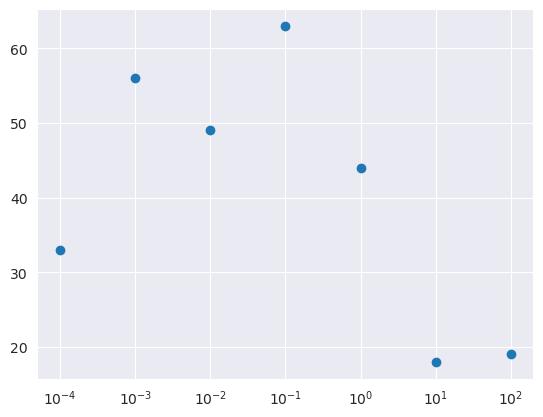

In [325]:
# plot learning rate vs exploration index plot in log scale
_ = plt.plot(lrs, exploration_index, 'o')
plt.xscale('log')

In [326]:
for lr in lrs:
    print(f'Best score for lr={lr}: {np.min(lrs_timeline[lr]):.3f}')

Best score for lr=0.0001: -12.915
Best score for lr=0.001: -12.914
Best score for lr=0.01: -12.914
Best score for lr=0.1: -12.914
Best score for lr=1: -12.914
Best score for lr=10: -12.914
Best score for lr=100: -12.914


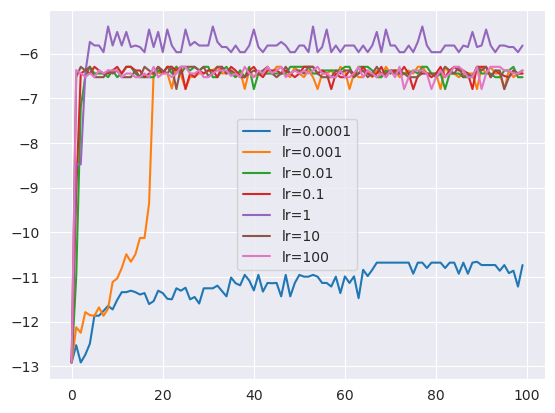

In [327]:
for lr in lrs:
    _ = plt.plot(lrs_timeline[lr], label=f'lr={lr}')
plt.legend()

In [328]:
from scipy import stats

In [329]:
#percentile of each best logP
for lr, exp in zip(lrs, exploration_index):
    print(f'Percentile of best score for lr={lr}: {stats.percentileofscore(target, np.min(lrs_timeline[lr]))} with {exp} samples')

Percentile of best score for lr=0.0001: 10.032765866514708 with 33 samples
Percentile of best score for lr=0.001: 10.032765866514708 with 56 samples
Percentile of best score for lr=0.01: 10.032765866514708 with 49 samples
Percentile of best score for lr=0.1: 10.032765866514708 with 63 samples
Percentile of best score for lr=1: 10.032765866514708 with 44 samples
Percentile of best score for lr=10: 10.032765866514708 with 18 samples
Percentile of best score for lr=100: 10.032765866514708 with 19 samples


In [330]:
stats.percentileofscore(target, -6)

99.80233634874278

In [331]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(space.mol2vec)

PCA(n_components=2)

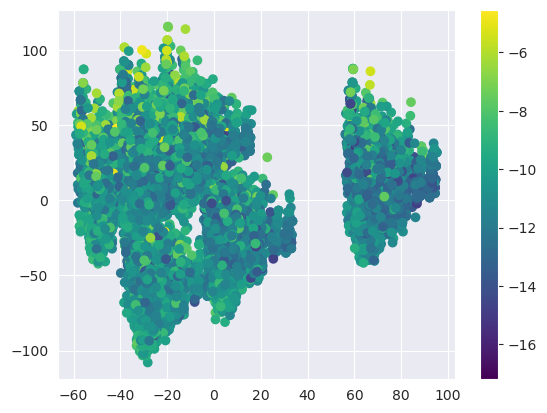

In [332]:
# plot PCA of mol2vec, use target as color
_ = plt.scatter(pca.transform(space.mol2vec)[:, 0], pca.transform(space.mol2vec)[:, 1], c=target, cmap='viridis')
plt.colorbar()

In [333]:
def create_distribs(mol2vec):
    means = np.ones(mol2vec.shape[1])
    stds = np.ones(mol2vec.shape[1])
    for i in range(mol2vec.shape[1]):
        means[i] = np.mean(mol2vec[:, i])
        stds[i] = np.std(mol2vec[:, i])
    return means, stds

In [334]:
means, stds = create_distribs(space.mol2vec)

In [335]:
def sample_from_distribs(means, stds):
    return np.random.normal(means, stds)

In [336]:
# test evrything with lr 10
global_seed(676550)
X = torch.randn(300, requires_grad=True, dtype=torch.float64)
optimizer = Adam([X], lr=1)
CALLS = []
history = np.zeros(20000)

Global seed set to 676550


In [337]:
best = 0
best_X = None
space.reset_neighbors()
for i in range(20000):
    optimizer.zero_grad()
    loss = space.f(X)
    loss.backward()
    optimizer.step()
    history[i] = loss.item()
    if loss.item() < best:
        best = loss.item()
        best_f = space.f(X)
        best_X = X.clone().detach()
    if i % 500 == 0:
        print(f'Iteration {i}: {loss.item()}, neighbors: {space.get_neighbors(X.detach().numpy())}')

Iteration 0: -11.946409311848065, neighbors: [[ 5641 15786  3982 10709 24359]]
Iteration 500: -9.447795795457074, neighbors: [[ 5641  3982  7116 21979 15786]]
Iteration 1000: -9.448085215692757, neighbors: [[ 5641  3982  7116 21979 15786]]
Iteration 1500: -9.138358157870641, neighbors: [[ 5641  3982  7116 21979  7847]]
Iteration 2000: -9.448068439223118, neighbors: [[ 5641  3982  7116 21979 15786]]
Iteration 2500: -9.158549623020042, neighbors: [[ 5641  3982  7116 21979 15786]]
Iteration 3000: -9.697060295185945, neighbors: [[ 5641  3982  7116 15786  7847]]
Iteration 3500: -9.138375396443049, neighbors: [[ 5641  3982  7116 21979  9118]]
Iteration 4000: -9.448077771464302, neighbors: [[ 5641  3982  7116 21979 15786]]
Iteration 4500: -9.158616551707066, neighbors: [[ 5641  3982  7116 21979 15786]]
Iteration 5000: -9.138411139166564, neighbors: [[ 5641  3982  7116  7847 15786]]
Iteration 5500: -9.138356595292912, neighbors: [[ 5641  3982  7116  7847 21979]]
Iteration 6000: -9.138446110493

In [338]:
space.get_neighbors(X.detach().numpy())
for i in space.get_neighbors(X.detach().numpy())[0]:
    print(space.get_objective(i))

-8.700000000000001
-8.533333333333333
-8.5
-10.666666666666666
-10.800000000000002


In [339]:
print(f'Visited {unique_comps(space.iter_neighbors)} unique compounds')
print(f'Best score: {best}')
print(f'Percentile: {percentileofscore(target, best)}')
print(f'Best f(X): {best_f}')

Visited 18 unique compounds
Best score: -11.946409311848065
Percentile: 33.46392193176152
Best f(X): -9.727315544899836


In [340]:
space.f(best_X)

tensor(-9.7273, dtype=torch.float64, grad_fn=<SumBackward0>)

In [341]:
np.sum(target < best)

9396

In [342]:
for i in space.get_neighbors(best_X)[0]:
    print(space.get_objective(i))

-8.700000000000001
-10.800000000000002
-8.533333333333333
-11.533333333333331
-9.066666666666666


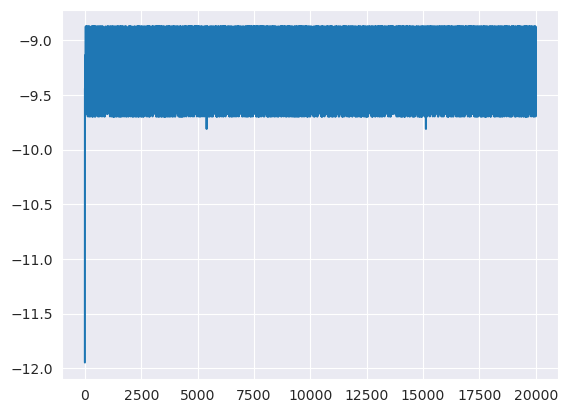

In [343]:
_ = plt.plot(history)

In [344]:
best_X

tensor([-1.3064, -0.9466, -0.5629, -1.5579, -0.6008, -1.8168,  0.2880,  4.0202,
         0.1866, -3.2319,  2.6615, -0.8742,  0.9014,  1.2279,  1.3715, -0.9194,
         0.2271,  1.7233, -2.0638, -1.4499,  2.4369, -1.8107, -1.9470, -1.6692,
         0.5711, -2.0487,  0.1444, -0.0197,  1.2852, -3.1619, -0.1121,  1.1677,
        -0.3950, -0.3872, -2.4766, -0.2596,  0.4621,  0.9706, -0.0481,  0.3432,
        -1.3269, -2.0396, -1.8726, -0.3697,  1.0625,  2.0893, -0.0997, -1.6993,
         1.3986,  0.0173, -0.8231,  0.8629,  2.9890,  0.6960, -1.5159, -0.7489,
        -0.3987,  0.3096, -1.4971,  0.0724, -2.0357,  1.0187, -1.6119, -1.2246,
        -1.0103,  1.1075,  1.4419,  1.8739,  0.8470, -2.8989, -1.7403, -0.3003,
        -2.8843,  0.9760, -1.2235, -1.8343, -1.7358, -0.4094, -1.1295,  1.4052,
         1.8333,  0.0203,  1.0356, -0.0431,  0.3530,  1.5308, -1.7489,  1.5517,
         0.8195,  1.3147,  1.5807, -1.0892,  0.5687, -0.6821,  0.9534, -0.8177,
         1.6818,  1.2406, -1.3411, -0.56

In [345]:
space.f(best_X)

tensor(-9.7273, dtype=torch.float64, grad_fn=<SumBackward0>)

In [346]:
space.get_neighbors(best_X)

array([[ 5641, 15786,  3982, 10709, 24359]])

In [347]:
for i in space.get_neighbors(best_X)[0]:
    print(space.get_objective(i))

-8.700000000000001
-10.800000000000002
-8.533333333333333
-11.533333333333331
-9.066666666666666


In [348]:
space.mol2vec.shape

(28078, 300)

In [67]:
global_seed(676550)
X = torch.tensor(sample_from_distribs(means, stds), requires_grad=True, dtype=torch.float64)
optimizer = Adam([X], lr=1)
CALLS = []
history = np.zeros(20000)
X_positions = np.zeros((20000, 300))
x_scores = np.zeros(20000)

Global seed set to 676550


In [68]:
best = 0
best_X = None
space.reset_neighbors()
for i in range(5000):
    optimizer.zero_grad()
    loss = space.f(X)
    loss.backward()
    optimizer.step()
    history[i] = loss.item()
    X_positions[i] = X.detach().numpy()
    x_scores[i] = loss.item()
    if loss.item() < best:
        best = loss.item()
        best_f = space.f(X)
        best_X = X.clone().detach()
    if i % 100 == 0:
        print(f'Iteration {i}: {loss.item()}, neighbors: {space.get_neighbors(X.detach().numpy())}')

Iteration 0: -12.100007844530078, neighbors: [[ 3294 12371  8780  5643  8772]]
Iteration 100: -12.326703583902228, neighbors: [[ 5643 16396   192 17742  5653]]
Iteration 200: -12.326657055484972, neighbors: [[ 5643   192  5653 16396 17742]]
Iteration 300: -12.326666567489246, neighbors: [[ 5643   192 16396  5653 17742]]
Iteration 400: -12.326678440410461, neighbors: [[ 5643 16396   192 17742  5653]]
Iteration 500: -11.866811881312053, neighbors: [[16396 17742 20982 20860 18904]]
Iteration 600: -12.013362755369496, neighbors: [[16396 17742 20982  1619 20860]]
Iteration 700: -12.173344873176646, neighbors: [[16396 17742 20982  1619  2138]]
Iteration 800: -12.206673945361125, neighbors: [[16396 17742 20982  1619 10773]]
Iteration 900: -12.20667534829185, neighbors: [[16396 17742 20982  1619 10773]]
Iteration 1000: -12.20667680214561, neighbors: [[16396 17742 20982 10773  1619]]
Iteration 1100: -12.206678129305171, neighbors: [[16396 17742 20982 10773  1619]]
Iteration 1200: -12.2066798125

In [69]:
print(f'Visited {unique_comps(space.iter_neighbors)} unique compounds')
print(f'Best score: {best}')
print(f'Percentile: {percentileofscore(target, best)}')
print(f'Best f(X): {best_f}')

Visited 84 unique compounds
Best score: -13.186714786173315
Percentile: 6.570980839091104
Best f(X): -13.120103556965073


In [70]:
# ne

In [71]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
all_points = np.concatenate((space.mol2vec, X_positions), axis=0)
all_tsne = tsne.fit_transform(all_points)

In [72]:
# separate mol2vec and X_positions
mol2vec_tsne = all_tsne[:space.mol2vec.shape[0]]
X_positions_tsne = all_tsne[space.mol2vec.shape[0]:]

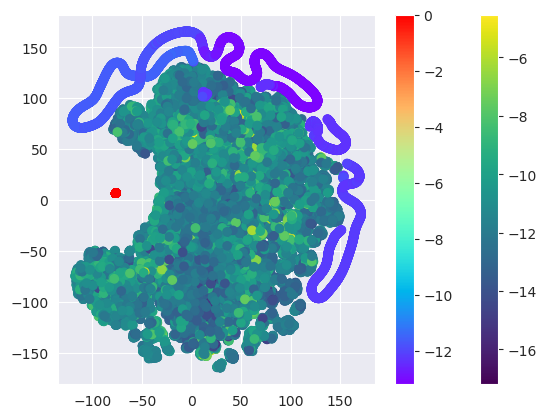

In [73]:
# plot TSNE of mol2vec, use target as color
_ = plt.scatter(mol2vec_tsne[:, 0], mol2vec_tsne[:, 1], c=target, cmap='viridis')
_ = plt.colorbar()
_ = plt.scatter(X_positions_tsne[:, 0], X_positions_tsne[:, 1], c=x_scores, cmap='rainbow')
# add two colorbar with name
plt.colorbar()

In [73]:
X_positions_pca = pca.transform(X_positions)

In [148]:
!mkdir images_tsne

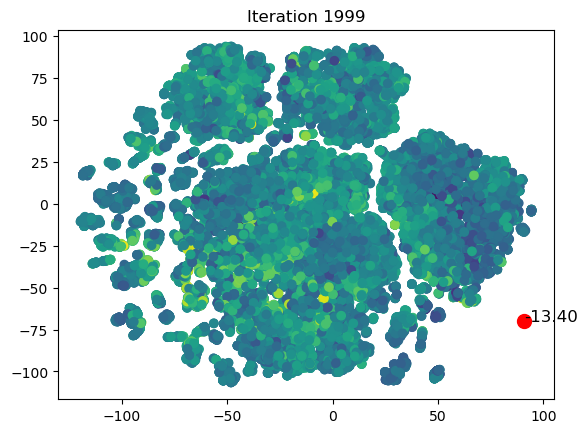

In [150]:
import imageio
images = []
for i in range(0, 2000, 1):
    plt.clf()
    plt.scatter(mol2vec_tsne[:, 0], mol2vec_tsne[:, 1], c=target, cmap='viridis')
    plt.scatter(X_positions_tsne[i, 0], X_positions_tsne[i, 1], c='red', s=100)
    plt.text(X_positions_tsne[i, 0], X_positions_tsne[i, 1], f'{x_scores[i]:.2f}', fontsize=12)
    plt.title(f'Iteration {i}')
    plt.savefig(f'images_tsne/{i}.png')
    images.append(imageio.v2.imread(f'images_tsne/{i}.png'))

In [151]:
# save as video
imageio.mimsave('movie_28k_lr10_tsne.mp4', images)